# Data exploration

In [1]:
# <api>
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from airbus_dataloader import *

In [2]:
# <api>
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [2]:
# <api>
path = '../../airbus/'
path_train = path + 'train/'
path_test = path + 'test/'

In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

tensor([1, 0, 0, 0, 1, 0, 0, 0])


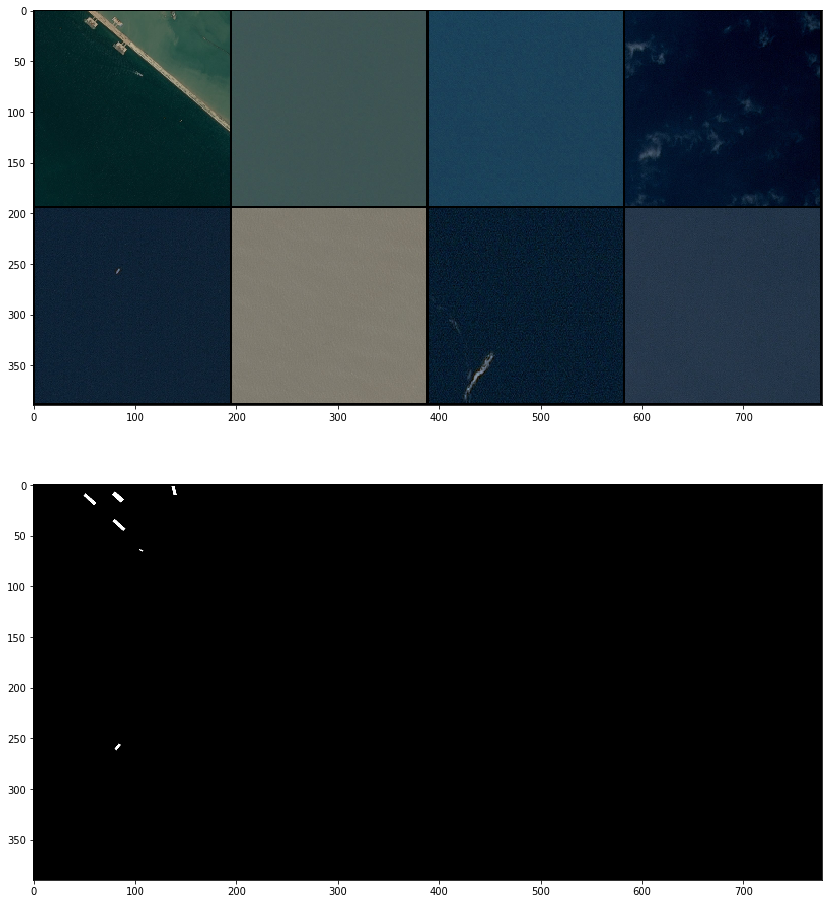

In [8]:
# Define the arguments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
is_gpu = torch.cuda.is_available()
batch_size = 8
workers = 4
aug=True
resize_factor=4
empty_frac=1
test_size=0.1

# Create data sets/loaders
dataset = AirbusDS(torch.cuda.is_available(), batch_size, workers, path, aug, resize_factor, empty_frac, test_size)
trainloader = dataset.train_loader

# get some images
dataiter = iter(trainloader)
images, masks, labels = dataiter.next()

# show images
plt.figure(figsize=(16,16))
plt.subplot(211)
imshow(torchvision.utils.make_grid(images, nrow=4))
plt.subplot(212)
imshow(torchvision.utils.make_grid(masks, nrow=4))
print(labels)

# Some calculations and histograms from the datset

In [21]:
masks = pd.read_csv(str(path+'train_ship_segmentations.csv'))

In [22]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

In [23]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images 


In [27]:
print('The whole train set has', unique_img_ids.shape[0], 'images.')

The whole train set has 103874 images.


In [25]:
# Drop corrupted images
unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(path_train, c_img_id)).st_size/1024)

unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>40] # keep only >40kb files
print('After droping corrupted and small images we have', unique_img_ids.shape[0], 'images')
ships = unique_img_ids[unique_img_ids['has_ship']==1]
no_ships = unique_img_ids[unique_img_ids['has_ship']==0].sample(frac=1)  #take only frac of empty images
files = pd.concat([ships, no_ships], axis=0)

After droping corrupted and small images we have  103874  images


In [30]:
print('The number of empty images: ', no_ships.shape[0])

The number of empty images:  74814


### The ratio of empty images and the number of ships per image (not empty)

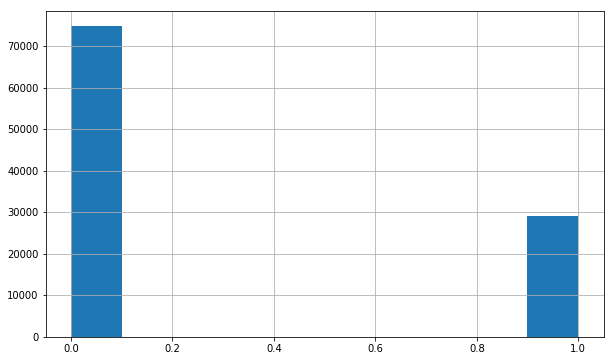

In [31]:
files['has_ship'].hist(figsize=(10,6))

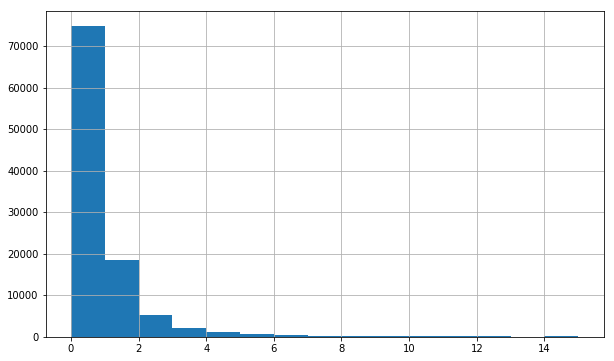

In [43]:
files['ships'].hist(figsize=(10,6), bins=15)